In [2]:
from fit_modelSignal import *
from fit_modelControl import *
from scipy.optimize import minimize
import numdifftools as nd

from utility_commonPlot import *

from timeit import default_timer as timer

In [3]:
baseDir = common.getBaseDirectory()
shaping = True


if shaping:
    X0 = np.load(baseDir + "data/templates/shaping_signalRegion/X_.npy")
    X1 = np.load(baseDir + "data/templates/shaping_controlRegion/X_.npy")
    Y0 = np.load(baseDir + "data/templates/shaping_signalRegion/Y_.npy")+0.01
    Y1 = np.load(baseDir + "data/templates/shaping_controlRegion/Y_.npy")+0.01
else:
    X0 = np.load(baseDir + "data/templates/counting_signalRegion/X_.npy")
    X1 = np.load(baseDir + "data/templates/counting_controlRegion/X_.npy")
    Y0 = np.load(baseDir + "data/templates/counting_signalRegion/Y_.npy")+0.01
    Y1 = np.load(baseDir + "data/templates/counting_controlRegion/Y_.npy")+0.01

    
# Y0 = np.sum(X0,axis=1)+0.1
# Y1 = np.sum(X1,axis=1)+0.1

model0 = PredictiveModel_Signal (X0,shaping)
model1 = PredictiveModel_Control(X1,shaping)


# define Model

In [4]:
def loss (rparam):
    slt1 = np.array([1,9])
    slt2 = np.array([0])
    
    r,bwl,theta = rparam[0],rparam[1],rparam[2:]
    bwt = bwl*r
    beta = np.array([bwl,bwl,bwt])
    param = np.r_[beta,theta]
    
    y0 = model0.predict(param)
    y1 = model1.predict(param)
    loss  = np.sum( (y0[slt1]-Y0[slt1])**2/(2*Y0[slt1]) )
    loss += np.sum( (y1[slt2]-Y1[slt2])**2/(2*Y1[slt2]) )
    loss += np.sum( (param[2:]**2)/2  )
    return loss

param0 = np.array([1.0,0.108] + [0.0]*22)
start = timer()
result = minimize( loss, param0, method='SLSQP', bounds = [(0,2),(0,1)] + [(-1,1)]*22 )
end   = timer()
print(result.x[:2])

print('fitting time = {:6.4f} ms'.format( (end-start)*1000 ))

[0.99413948 0.10992225]
fitting time = 565.7215 ms


hessian time = 2402.1228 ms


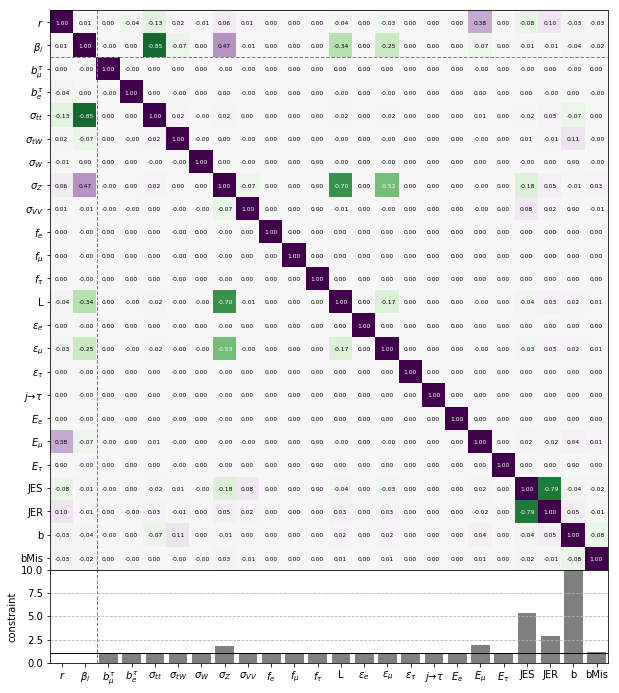

In [34]:
start = timer()
hcalc = nd.Hessian(loss, step=1e-4, method='central')
hess  = hcalc( result.x )
end   = timer()
hessinv = np.linalg.inv(hess)
sig   = np.sqrt(hessinv.diagonal())
cor  = hessinv/np.outer(sig, sig)

print('hessian time = {:6.4f} ms'.format( (end-start)*1000 ))
commonp.showParameterCovMat(cor,sig,False)
plt.savefig('../plots/fit/cov_r.png',dpi=300)

In [35]:
for i in range(sig.size):
    c,s = result.x[i], sig[i]
    print('{:7.4f} +/- {:6.4f}'.format(c,s))

 0.9941 +/- 0.0462
 0.1099 +/- 0.0030
 0.0001 +/- 1.0000
 0.0000 +/- 1.0000
-0.7064 +/- 0.9785
-0.3658 +/- 0.9953
-0.1604 +/- 0.9999
-0.5468 +/- 0.5586
 0.6060 +/- 0.9968
 0.0000 +/- 1.0000
 0.0000 +/- 1.0000
 0.0000 +/- 1.0000
-0.7179 +/- 0.9104
 0.0000 +/- 1.0000
-0.5672 +/- 0.9435
 0.0000 +/- 1.0000
 0.0000 +/- 1.0000
 0.0000 +/- 1.0000
 0.4969 +/- 0.5093
 0.0000 +/- 1.0000
 0.5483 +/- 0.1871
 1.0000 +/- 0.3419
 0.2548 +/- 0.0941
-1.0000 +/- 0.8283


In [16]:
print(sig[0:3]/0.1080*100)
print(1/sig[3:])

[ 28.33628041   2.52587818 924.97744314]
[ 1.00126408  1.07495341  1.02109726  1.00023982  1.94521478  1.00575432
  1.0000004   1.0000004   1.0000004   1.10516636  1.45371353  1.45216152
  1.0000004   1.0000004   3.92063353  2.34678316  1.0000004   6.81382404
  3.67056754 17.82313039  1.39079971]


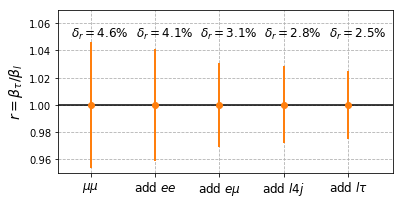

In [12]:
deltar = np.array([0.0462, 0.0412, 0.0308, 0.0283, 0.0252])
deltabwt = np.array([0.0101, 0.0054, 0.0046, 0.0027, 0.0024])#/0.108

pos = np.arange(5)+0.5
r = np.ones(5)
lable = [r'$\mu\mu$', r'add $ee$', r'add $e\mu$', r'add $l4j$', r'add $l \tau$']

plt.figure(facecolor='w',figsize=(6,3))

plt.errorbar(pos,r,yerr=deltar,fmt='o',color='C1',lw=2)
plt.axhline(1,color='k')
plt.xticks(pos,lable,fontsize=12)
plt.xlim(0,5.2)
plt.ylim(0.95,1.07)
plt.grid(linestyle='--')
plt.ylabel(r'$r=\beta_\tau / \beta_l$',fontsize=14)
for i in range(5):
    plt.text(pos[i]-0.3,1.05, r'$\delta_r=${:3.1f}%'.format(100*deltar[i]),fontsize=12)
plt.savefig('../plots/fit/gain.png',dpi=300)

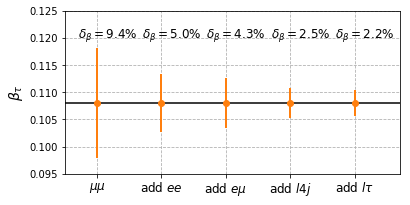

In [22]:
pos = np.arange(5)+0.5
r = np.ones(5)*0.108
lable = [r'$\mu\mu$', r'add $ee$', r'add $e\mu$', r'add $l4j$', r'add $l \tau$']

plt.figure(facecolor='w',figsize=(6,3))

plt.errorbar(pos,r,yerr=deltabwt,fmt='o',color='C1',lw=2)
plt.axhline(0.108,color='k')
plt.xticks(pos,lable,fontsize=12)
plt.xlim(0,5.2)
plt.ylim(0.095,0.125)
plt.grid(linestyle='--')
plt.ylabel(r'$\beta_\tau$',fontsize=14)
for i in range(5):
    plt.text(pos[i]-0.3,0.12, r'$\delta_\beta=${:3.1f}%'.format(100*deltabwt[i]/0.108),fontsize=12)
plt.savefig('../plots/fit/gainbwt.png',dpi=300)